# LAB 1: Metric Algorithms
### AI and Machine Learning // Suchkova Natalia М8О - 114М - 22
17.03.23 @ MAI IT-Center

## The Task
1. Применить метод K ближайших соседей  (KNN ядерный), взвешенный алгоритмом STOLP для пяти классов, сгенерированных с помощью MakeClassification

2. (*) Для сгенерированного датасета создать профиль компактности

3. Для сгенерированного датасета, произвести оптимизацию по выбору ширины окна (или метод меняющегося окна)

4. Найти датасет с картинками (2-3 класса) небольшой (100 картинок достаточно, классифицированных). Найти метод\библиотеку для построения embedding (векторизации) изображений. Применить этот метод на картинки. Применить КNN (без оптимизации) для полученного датасета из векторизованных картинок.

5. (*) Задание 4 со своими фотографиями.

<a id='g0'></a>
## Table of Contents


1. [**KNN**](#g1)


2. [**STOLP**](#g2)


3. [**Профиль компактности**](#g3)


4. [**Метод окна Парзена для KNN**](#g4)
    
    
5. [**KNN для векторизованных картинок**](#g5)
    
    - [Загружаем Headgear датасет](#g51)
    - [Подготовка](#g52)
    - [scale + normalize + umap](#g53)


6. [**Классификация своих картинок**](#g6)
    

In [81]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import plotly.express as px
from mlxtend.plotting import plot_decision_regions

from typing import Mapping
import math

from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

from sklearn.neighbors import KNeighborsClassifier, NearestNeighbors


from scipy.spatial import KDTree

In [82]:
seed = np.random.seed(11)

## Задание 1.

#### Генерим данные

In [91]:
X, Y = make_classification(n_samples=1000, n_features=3, 
                           n_informative=3, n_classes=5, 
                           n_redundant=0,
                           n_clusters_per_class=1,
                           random_state=seed)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, 
                                                    test_size=0.2, 
                                                    random_state=seed)

<a id='g1'></a>
### KNN

In [92]:
model = KNeighborsClassifier(n_neighbors=6)
model.fit(X_train, Y_train)

KNeighborsClassifier(n_neighbors=6)

In [93]:
predictions = model.predict(X_test)

In [94]:
model.kneighbors(X_test, return_distance=False)

array([[575, 756, 204, 515, 552, 725],
       [772, 428, 422, 496, 571, 704],
       [222, 473, 419, 128, 390, 314],
       ...,
       [650, 795, 121, 151, 438,  31],
       [141, 777, 155, 438, 634, 693],
       [357, 707, 706, 678, 165, 418]], dtype=int64)

In [95]:
model.kneighbors(X_test[5].reshape(1, -1), return_distance=False)

array([[162, 685, 389, 289, 210,  27]], dtype=int64)

In [96]:
def plot(data, preds, title, marker='o', size=30):
    colors = ['#FF5733', '#BFFF4B', '#5966DA', '#FFC300', '#D859DA']
    c = [colors[i] for i in preds]
    fig = plt.figure()
    ax = fig.add_subplot(111, 
                         projection='3d'
                        )
    ax.set_title(title)
    ax.scatter(data[ : , 0], 
               data[ : , 1], 
               data[ : , 2], 
               c=c, marker=marker,
               s=size)
    plt.show()
    
    
def plot_compare(data, labels, lbl_preds, size=60, title=''):
    
    colors = ['#FF5733', '#BFFF4B', '#5966DA', '#FFC300', 
              '#D859DA', '#DAF7A6', '#4BFCFF', '#581845']
    
    fig = plt.figure(figsize=plt.figaspect(0.3))
    
    ax1 = fig.add_subplot(1, 2, 1, projection='3d')
    ax1.set_title('Реальные значения')
    c = [colors[i] for i in labels]
    ax1.scatter(data[ : , 0], 
                data[ : , 1], 
                data[ : , 2], 
                c=c, s=size)

    ax2 = fig.add_subplot(1, 2, 2, projection='3d')
    ax2.set_title(f'Наши предсказания {title}')
    c = [colors[i] for i in lbl_preds]
    ax2.scatter(data[ : , 0], 
                data[ : , 1], 
                data[ : , 2], 
                c=c, s=size)
    
    plt.show()

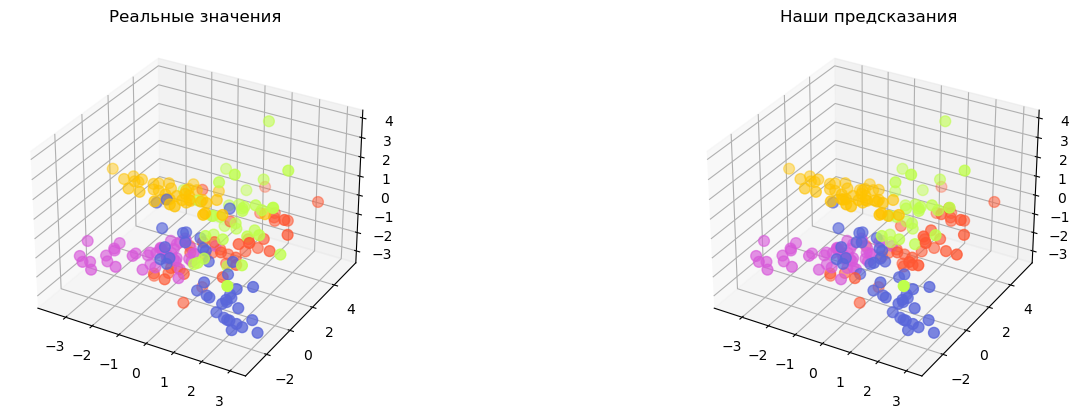

In [97]:
plot_compare(X_test, Y_test, predictions)

In [98]:
print(classification_report(Y_test, predictions))

              precision    recall  f1-score   support

           0       0.74      0.72      0.73        40
           1       0.83      0.63      0.72        38
           2       0.85      0.92      0.89        38
           3       0.88      0.95      0.92        40
           4       0.88      0.95      0.91        44

    accuracy                           0.84       200
   macro avg       0.84      0.84      0.83       200
weighted avg       0.84      0.84      0.84       200



<a id='g2'></a>
### STOLP  
— алгоритм отбора эталонных объектов для метрического классификатора.

Пусть дана обучающая выборка $X^l=(x_i, y_i)_{i=1}^l$, где $x_i$ — объекты, $y_i=y^*(x_i)$ — классы, которым принадлежат эти объекты. 

Кроме того, задана метрика $\rho \: X \times X \rightarrow \mathbb{R}$, такая, что выполняется гипотеза компактности. 

При классификации объектов метрическим классификатором $$a(u, X^l) = \mathrm{arg}\max_{y\in Y} \Gamma_y (u, X^l) = \mathrm{arg}\max_{y\in Y} \sum_{i=1}^l[y_u^(i)=y]w(i, u),$$ например, `методом ближайших соседей` необходимо вычислять расстояния от классифицируемого объекта до всех объектов обучающей выборки. 

Минусы: Время, затрачиваемое на это для каждого классифицируемого объекта, пропорционально размеру обучающей выборки. Кроме того, оказывается необходимым хранить большой объем данных.

Но не все объекты обучающей выборки равноценны. 

Среди них есть
- наиболее типичные представители классов, то есть **эталоны**; 
- **неинформативные объекты**, при удалении которых из обучающей выборки качество классификации не изменится;
- **выбросы, или шумовые объекты** — объекты, находящиеся в гуще «чужого» класса, только ухудшающие качество классификации.

Поэтому необходимо уменьшить объем обучающей выборки, оставив в ней только эталонные объекты для каждого класса.

**Oтступ (margin)** показывает насколько истинный класс далеко от другого класса. Отступ объекта показывает нам, насколько глубоко текущий объект лежит в пределах своего класса. Например, если почти все ближайшие соседи некоторого объекта x_i принадлежат к тому же классу, что и сам x_i, мы можем сказать, что у него очень положительный отступ. С другой стороны, если почти все ближайшие соседи принадлежат к другому классу, чем x_i, отступ должен быть отрицательным. Мы можем вычислить маржу таким образом: в случае, если отступ положительный, то предсказание является верным. В случае, если отступ отрицательный, то предсказание является ошибочным.

Но для начала нужно сделать несколько шагов:

1. Для каждого элемента выборки найти сумму евклидового расстояния до ближайших n соседей;

2. Отсортировать элементы выборки по сумме расстояний;

3. Взять первые N элементов - они и будут эталонными объектами.

https://jet1black.wordpress.com/2015/10/03/stolp-algorithm-implementation/

In [99]:
def compute_margins(xkd, x, y, u, u_ans, n_neigh):
    result = []
    bound = min(n_neigh, y.shape[0]) # задаем количество ближайших соседей для исследования
    
    for cur_u_idx, cur_u_coord in enumerate(u):  # задаем индекс каждой точке в u
        idx = xkd.kneighbors(cur_u_coord.reshape(1, -1), return_distance=False)
        idx = idx.tolist()[0]  # сохраняем индексы ближайших соседей
        maj = {}
        
        for i in idx:
            y_cur = y[i]  # перебираем все класс в ближайших соседях по их индексу
            di = np.linalg.norm(cur_u_coord - x[i])  # расстояние от текущей точки до каждой точки в данных
            dn = np.linalg.norm(cur_u_coord - x[idx[bound - 1]])  # расстояние от текущей точки до предыдущей из n соседей
            w = 0.0
            
            if di != 0.0 and dn > di:
                w = dn / di
                
            maj[y_cur] = maj.get(y_cur, 0) + w  # обновляем в словаре по индексу точки ее вес, 
                                                # если новая точка, то ее вес 0 сначала
            
        cur_u_ans = u_ans[cur_u_idx] # находим в Y_train по текущему индексу класс [u_ans[cur_u_idx]][0]
        correct_score = maj.get(cur_u_ans, 0)  # достаем из словаря вес точки
        del maj[cur_u_ans]
        
        max_wrong = 0
        if len(maj) > 0:
            max_wrong = sorted(maj.items(), key=lambda x: x[1])[-1][1] # находим максимально отдаленный элемент (точку)
            
        result.append(correct_score - max_wrong)  # для рассчета конечной удаленности вычитаем самый большой отступ
        
    return np.array(result)

In [100]:
model = KNeighborsClassifier(n_neighbors=7).fit(X_test, Y_test)

In [101]:
margins = compute_margins(model, X_test, Y_test, X_test, Y_test, 7)

def compute_margins(xkd, x, y, u, u_ans, n):  мы считаем отступ для всех точек, поэтому у нас х и и это одно и то же
margins = compute_margins(KDTree(X_test), X_test, Y_test, X_test, Y_test, 5)

In [102]:
len(margins)

200

In [103]:
def stolp(src_x, src_y, err_num, depth_limit, n):

    support_x = []
    support_y = []
    src_xkd = KNeighborsClassifier(n_neighbors=n).fit(src_x, src_y)
    print(src_xkd)
    margins = np.array([compute_margins(src_xkd, src_x, src_y, src_x, src_y, n)]).transpose()
    
    x = src_x[margins[:, 0] > depth_limit]
    y = src_y[margins[:, 0] > depth_limit]
    margins = margins[margins[:, 0] > depth_limit]
    sorted_margs = np.argsort(margins[:, 0])

    for ans in np.unique(y):
        for m in sorted_margs:

            if y[m] == ans:

                support_x.append(x[m])
                support_y.append(y[m])
                x = np.delete(x, (m), axis=0)
                y = np.delete(y, (m), axis=0)
                break
                
    errors = x.shape[0]
#     print(support_x, support_y)
    while errors > err_num:
        xkd = KNeighborsClassifier(n_neighbors=n).fit(np.array(support_x), np.array(support_y))
        margins = compute_margins(xkd, np.array(support_x), np.array(support_y), x, y, n)
        KNN_preds = model.predict(support_x)

        errors = len(KNN_preds[KNN_preds == src_y[:len(KNN_preds)]])
        sorted_margs = np.argsort(margins)  # выводим индексы отсортированных отступов
        to_delete = []
        min = sorted_margs[0]
        support_x.append(x[min])
        support_y.append(y[min])
        to_delete.append(min)
        
        x = np.delete(x, to_delete, axis=0)
        y = np.delete(y, to_delete, axis=0)
        
    return np.array(support_x), np.array(support_y)

In [104]:
stolp_prx, stolp_pry = stolp(X_test, Y_test, err_num=60, depth_limit=0.0001, n=5)

KNeighborsClassifier()


In [105]:
stolp_prx

array([[ 0.16234674,  0.46846048, -0.7784959 ],
       [ 1.3015293 ,  1.30024013,  1.0617255 ],
       [ 1.72208996, -1.08737766, -2.31885603],
       [-0.9403541 ,  0.21330502,  1.14653194],
       [-1.33225733, -1.9046816 , -0.76541665],
       [-0.1840596 ,  0.24612905, -1.1008799 ]])

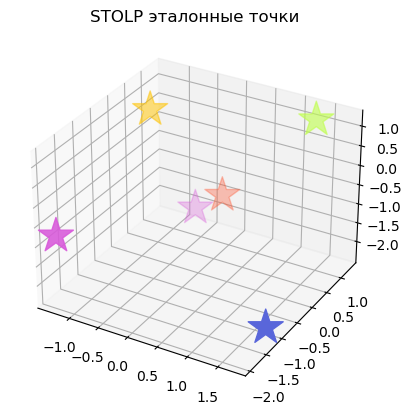

In [106]:
plot(stolp_prx, stolp_pry, 'STOLP эталонные точки', '*', 700)

<a id='g3'></a>
### Профиль компактности

Профиль компактности выборки в метрических алгоритмах классификации — функция R(j), выражающая долю объектов выборки, для которых правильный ответ не совпадает с правильным ответом на j-м соседе.

Рассматривается задача классификации. Имеется множество объектов X и множество имён классов Y. Задана обучающая выборка пар «объект—ответ» $X^m = \{(x_1,y_1),\ldots,(x_m,y_m)\} \in X\times Y$.

Пусть на множестве объектов задана функция расстояния $\rho(x,x')$. Эта функция должна быть достаточно адекватной моделью сходства объектов. Чем меньше значение этой функции, тем более схожи объекты $x,x'$.

Для произвольного объекта $u$ расположим объекты обучающей выборки $x_i$ в порядке возрастания расстояний до $u$:

$$\rho(u,x_{1; u}) \leq  \rho(u,x_{2; u}) \leq \cdots \leq \rho(u,x_{m; u}),$$
где через $x_{i; u}$ обозначается элемент обучающей выборки, который является i-м соседом объекта $u$. Аналогичное обозначение введём и для ответа на i-м соседе: $y_{i; u}$. Каждый объект $u\in X$ порождает свою перенумерацию выборки.

Рассматривается метод ближайшего соседа, который относит классифицируемый объект $u$ к тому классу, которому принадлежит ближайший к $u$ объект обучающей выборки:

$a(u,X^m) = y_{1;u}$.

Профиль компактности выборки $X^m$ есть функция

$$R(j,X^m) = \frac1m \sum_{i=1}^m \left[ y_i \neq y_{j;x_i} \right]$$
Иными словами, профиль компактности R(j) — это доля объектов выборки, для которых j-й сосед лежит в другом классе.


Профиль компактности является формальным выражением гипотезы компактности — предположения о том, что схожие объекты гораздо чаще лежат в одном классе, чем в разных. *Чем проще задача, то есть чем чаще близкие объекты оказываются в одном классе, тем сильнее «прижимается к нулю» начальный участок профиля. В сложных задачах или при неудачном выборе функции расстояния ближайшие объекты практически не несут информации о классах, и профиль вырождается в константу, близкую к 0.5.*

На рисунке показаны профили компактности для серии плоских модельных задач классификации с двумя классами. Чем ниже проходит начальный участок профиля, тем выше обобщающая способность метода ближайшего соседа.

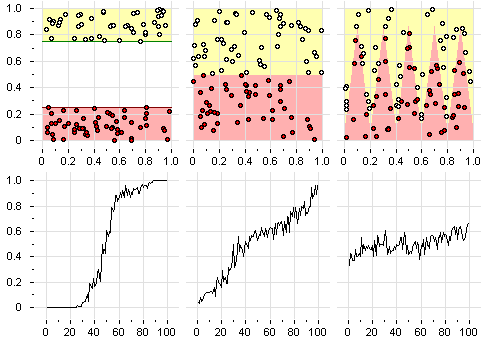

In [107]:
def compactness_profile(index:int, X, y, metric='euclidean'):
    """
    index: индекс
    X: матрица объект-признак, для которой хотим посчитать профиль компактности
    y: вектор таргетов для этих объектов
    metric: ['euclidean', 'cosine', ...]
    """
    assert 0 <= index <= X.shape[0]
    neigh = NearestNeighbors(n_neighbors=X.shape[0], metric=metric)
    neigh.fit(X, y)
    distances, indexes = neigh.kneighbors(X)
    return (y != y[indexes[:, index]]).mean() # возвращаем значения для профиля компактности

In [108]:
%%time
length = np.array(list(range(1, X_train.shape[0])))
comp_vals = np.array([compactness_profile(i, X_train, Y_train) for i in length])

fig = px.line(x=length, y=comp_vals)
fig.show()

Wall time: 50.5 s


<a id='g4'></a>
### Parzen Window Method

Восстановление плотности методом Парзена-Розенблатта
$$p(x)= \frac{1}{n}\displaystyle\sum_{i=1}^n \frac{1}{h^2} \phi \big(\frac{x_i−x_h}{h}\big)$$ - where n is number of elements in the vector, x is a vector, p(x) is a probability density of x, h is dimension of the Parzen Window, and $\phi$ is a window function.

In [109]:
gauss_kernel = lambda x: ((2 * math.pi) ** (-1/2)) * np.exp(-1/2 * (x ** 2))

In [110]:
distance = lambda point1, point2: math.sqrt((point1[0] - point2[0]) ** 2 \
                                            + (point1[1] - point2[1]) ** 2 \
                                            + (point1[2] - point2[2]) ** 2
                                           )

In [111]:
def ParzRos_score(x: float, h: float, data: np.array, kernel: Mapping, distance: Mapping) -> float:
    """
    Function: 
        Метод возвращает значение, найденное методом Парзена-Розенблатта для группы точек.

    Args: 
        x: float - параметр функции ядра.
        h: float - параметр метода Парзена-Розенблатта: ширина окна.
        data: list или array - набор точек.
        kernel: Mapping - тип ядра.
        distance: Mapping - функция расчета расстояния между двумя точками 
                        на плоскости или в пространстве (для нелинейной задачи).

    Return:
        Значение найденное методом Парзена-Розенблатта для группы точек (float).
    """
    return sum([kernel(distance(x, point) / h) for point in data]) / (len(data) * h)

In [112]:
ParzRos_score(X_train[3], 2, X_train, gauss_kernel, distance)

0.09617613719091925

#### Функция ядра (окна)
$K(z)$ — произвольная четная функция, называемая функцией ядра или окна. Термин окно происходит из классического вида функции:

$K(z) = \frac12 [|z| < 1]$

#### Ширина окна
Ширина окна сильно влияет на качество восстановления плотности и, как следствие, классификации. При слишком малом окне мы получаем тот же эффект, что и при использовании гистограммы значений. При слишком большом окне плотность вырождается в константу.

Для нахождения оптимальной ширины окна удобно использовать принцип максимума правдоподобия с исключением объектов по одному (leave-one-out, LOO).

#### Возможные проблемы
*Проблема локальных сгущений*

Возникает в тех случаях, когда распределение объектов в пространстве сильно неравномерно, и одно и то же значение ширины окна h приводит к чрезмерному сглаживанию плотности в одних местах, и недостаточному сглаживанию в других. Проблему решают окна переменной ширины.

*Проблема «проклятия размерности»*

Если число признаков велико и учитываются все они, то все объекты оказываются примерно на одинаковом расстоянии друг от друга. Выход заключается в понижении размерности с помощью преобразования пространства признаков, либо путём отбора информативных признаков.

In [113]:
def ParzWindow(distance: Mapping, h: float) -> float:
    """
    Function: 
        Метод возвращает значение, найденное методом окна Парзена для группы точек.

    Args: 
        distance: Mapping - расстояния между двумя точками 
                на плоскости или в пространстве.
        h: float - параметр метода Парзена: ширина окна.

    Return:
        Значения найденные методом окна Парзена для группы точек (float).
    """
    return (1 - (np.array(distance) / h) ** 2) * (np.abs(np.array(distance) / h) <= 1)

In [114]:
model_parz = KNeighborsClassifier(n_neighbors=3,
                                 weights=lambda x: ParzWindow(x, h=1.5))
                             #ParzRos_score(x, 0.05, X_train, gauss_kernel, distance)
model_parz2 = KNeighborsClassifier(n_neighbors=3,
                                 weights=lambda x: ParzWindow(x, h=122.2))

model_parz3 = KNeighborsClassifier(n_neighbors=3,
                                 weights=lambda x: ParzWindow(x, h=0.03))


model_parz.fit(X_train, Y_train)
model_parz2.fit(X_train, Y_train)
model_parz3.fit(X_train, Y_train)

KNeighborsClassifier(n_neighbors=3,
                     weights=<function <lambda> at 0x0000027C11B7FB88>)

In [115]:
predictions_parz = model_parz.predict(X_test)
predictions_parz2 = model_parz2.predict(X_test)
predictions_parz3 = model_parz3.predict(X_test)

In [116]:
predictions_parz

array([0, 3, 4, 0, 0, 2, 4, 4, 1, 2, 3, 4, 2, 2, 3, 4, 4, 3, 4, 4, 2, 2,
       3, 3, 1, 1, 0, 0, 2, 4, 0, 2, 4, 2, 0, 4, 3, 4, 2, 1, 4, 1, 0, 4,
       1, 2, 4, 0, 1, 4, 1, 1, 4, 1, 4, 4, 3, 0, 4, 3, 3, 2, 1, 3, 3, 1,
       3, 4, 2, 4, 0, 3, 3, 0, 3, 4, 2, 0, 4, 0, 3, 3, 2, 0, 4, 4, 2, 1,
       2, 3, 3, 1, 0, 1, 4, 3, 1, 1, 4, 4, 2, 3, 2, 4, 0, 4, 2, 1, 1, 2,
       1, 3, 0, 4, 3, 3, 3, 1, 1, 4, 2, 2, 1, 0, 3, 0, 3, 0, 0, 2, 0, 2,
       0, 4, 0, 2, 2, 4, 2, 4, 4, 4, 2, 0, 3, 4, 0, 3, 4, 3, 2, 3, 4, 3,
       3, 0, 4, 1, 2, 3, 0, 0, 3, 2, 2, 3, 1, 3, 3, 3, 4, 3, 3, 3, 4, 3,
       0, 2, 0, 4, 4, 0, 1, 2, 3, 2, 0, 1, 0, 4, 2, 0, 3, 3, 4, 2, 2, 0,
       0, 1])

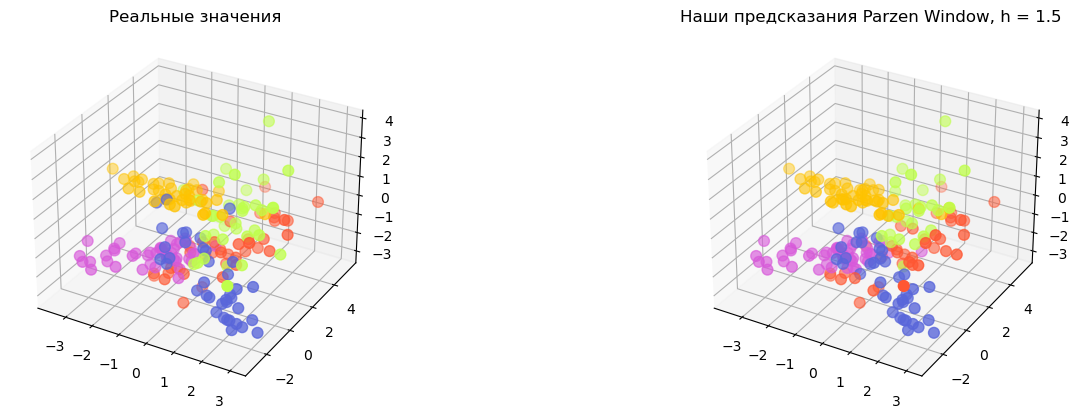

In [117]:
plot_compare(X_test, Y_test, predictions_parz, title='Parzen Window, h = 1.5')

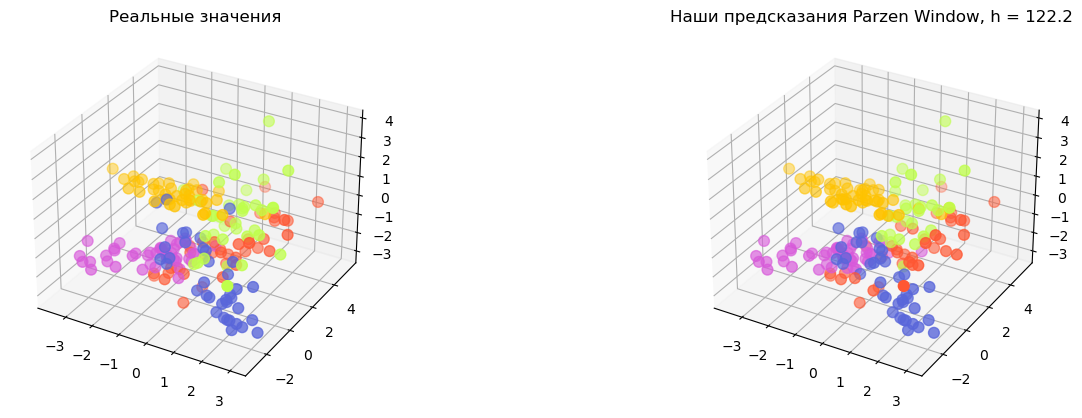

In [118]:
plot_compare(X_test, Y_test, predictions_parz2, title='Parzen Window, h = 122.2')

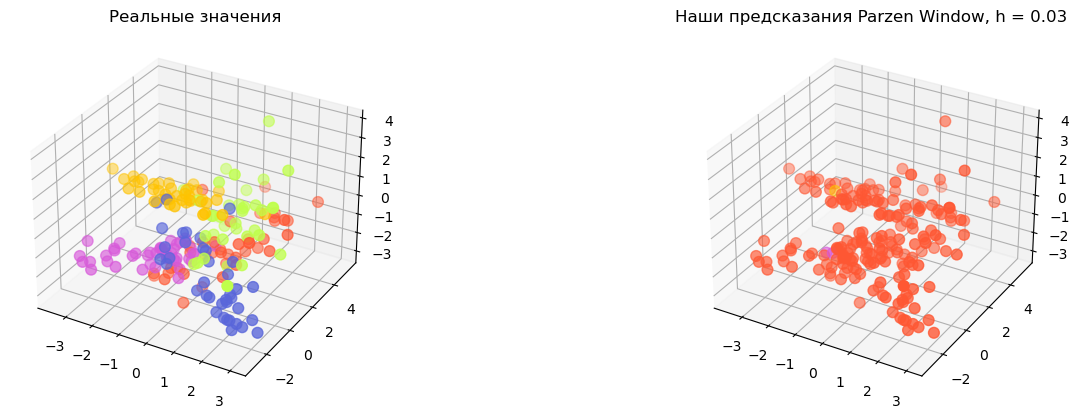

In [119]:
plot_compare(X_test, Y_test, predictions_parz3, title='Parzen Window, h = 0.03')

<a id='g5'></a>
###  KNN для векторизованных картинок

In [120]:
import os
import imutils
import cv2

import matplotlib.image as mpimg
import random

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Normalizer

<a id='g51'></a>
### Headgear Dataset

Image dataset of 20 classes of head gear-hats, caps, helmets. 3620 train images, 100 test and 100 validation images. All images are 224 X 224 X 3 in jpg format. 

https://www.kaggle.com/datasets/gpiosenka/headgear-image-classification

In [390]:
print(os.listdir("./headgear/train"))

['ASCOT CAP', 'BASEBALL CAP', 'BERET', 'BICORNE', 'BOATER', 'BOWLER', 'DEERSTALKER', 'FEDORA', 'FEZ', 'FOOTBALL HELMET', 'GARRISON CAP', 'HARD HAT', 'MILITARY HELMET', 'MOTARBOARD', 'PITH HELMET', 'PORK PIE', 'SOMBERO', 'SOUTHWESTER', 'TOP HAT', 'ZUCCHETTO']


#### Загружаем датасет с картинками

In [391]:
mark = pd.read_csv('./headgear/headgear.csv')
mark.rename(columns={'class id': 'class_id', 'data set': 'dataset'}, inplace=True)
mark

,class_id,filepaths,labels,dataset
0,0,train/ASCOT CAP/001.jpg,ASCOT CAP,train
1,0,train/ASCOT CAP/002.jpg,ASCOT CAP,train
2,0,train/ASCOT CAP/003.jpg,ASCOT CAP,train
3,0,train/ASCOT CAP/004.jpg,ASCOT CAP,train
4,0,train/ASCOT CAP/005.jpg,ASCOT CAP,train
...,...,...,...,...
3815,19,valid/ZUCCHETTO/1.jpg,ZUCCHETTO,valid
3816,19,valid/ZUCCHETTO/2.jpg,ZUCCHETTO,valid
3817,19,valid/ZUCCHETTO/3.jpg,ZUCCHETTO,valid
3818,19,valid/ZUCCHETTO/4.jpg,ZUCCHETTO,valid


In [392]:
print(f"Found {mark[mark['dataset'] == 'train'].shape[0]} train files belonging to {mark[mark['dataset'] == 'train']['class_id'].nunique()} classes.")
print(f"Found {mark[mark['dataset'] == 'test'].shape[0]} test files belonging to {mark[mark['dataset'] == 'test']['class_id'].nunique()} classes.")
print(f"Found {mark[mark['dataset'] == 'valid'].shape[0]} validation files belonging to {mark[mark['dataset'] == 'valid']['class_id'].nunique()} classes.")

Found 3620 train files belonging to 20 classes.
Found 100 test files belonging to 20 classes.
Found 100 validation files belonging to 20 classes.


(224, 224, 3)


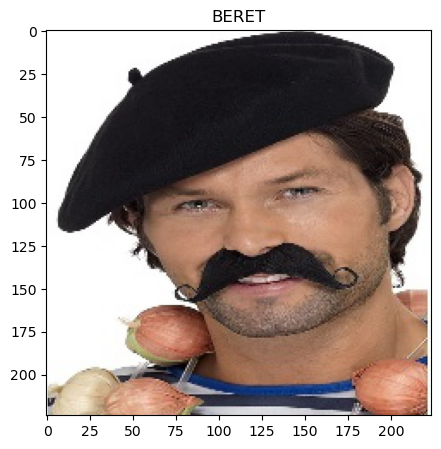

In [393]:
img=mpimg.imread('headgear/train/BERET/008.jpg')
print(img.shape)
plt.figure(figsize=(5, 5))
imgplot = plt.imshow(img)
plt.title(mark.iloc[mark[mark.filepaths == 'train/BERET/008.jpg'].index[0], 2])
plt.show()

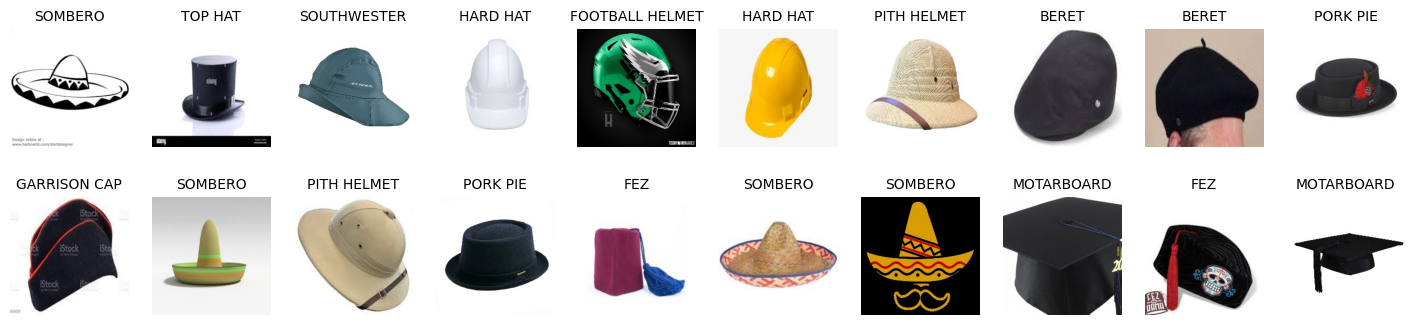

In [437]:
plt.figure(figsize=(18, 4))

for i in range(20):
    generated_img_path = mark.iloc[random.randint(0, 3620), 1]
    
    ax = plt.subplot(2, 10, i + 1)
    plt.imshow(mpimg.imread('headgear/' + generated_img_path))
    plt.title(mark.iloc[mark[mark.filepaths == generated_img_path].index[0], 2], fontsize=10)
    plt.axis("off")
        
plt.show()

In [395]:
#  все классы
mark[['class_id',  'labels']].value_counts()

class_id  labels         
14        PITH HELMET        286
15        PORK PIE           241
12        MILITARY HELMET    241
9         FOOTBALL HELMET    239
10        GARRISON CAP       233
16        SOMBERO            209
3         BICORNE            198
1         BASEBALL CAP       192
11        HARD HAT           188
8         FEZ                183
4         BOATER             182
18        TOP HAT            181
6         DEERSTALKER        171
0         ASCOT CAP          163
13        MOTARBOARD         163
5         BOWLER             159
7         FEDORA             155
2         BERET              150
19        ZUCCHETTO          146
17        SOUTHWESTER        140
dtype: int64

<a id='g52'></a>
#### Подготовка

In [508]:
# сделаем датасет поменьше
fin = pd.DataFrame()
for i in mark.class_id.unique():
    fin = pd.concat([fin, mark[(mark.dataset == 'train') & (mark.class_id == i)][:20], mark[(mark.dataset == 'test') & (mark.class_id == i)][:5]])

In [509]:
fin.dataset.value_counts()

train    400
test     100
Name: dataset, dtype: int64

In [510]:
def image_to_feature_vector(image, size=(224, 224)):
    return cv2.resize(image, size).flatten()

In [511]:
def extract_color_histogram(image, bins=(8, 8, 8)):
    # extract a 3D color histogram from the HSV color space using
    # the supplied number of `bins` per channel
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    hist = cv2.calcHist([hsv], [0, 1, 2], None, bins,
        [0, 180, 0, 256, 0, 256])
    # handle normalizing the histogram if we are using OpenCV 2.4.X
    if imutils.is_cv2():
        hist = cv2.normalize(hist)
    # otherwise, perform "in place" normalization in OpenCV 3 (I
    # personally hate the way this is done
    else:
        cv2.normalize(hist, hist)
    # return the flattened histogram as the feature vector
    return hist.flatten()

In [512]:
rawImages_tr = []
rawImages_tst = []

features_tr = []
features_tst = []

# for path in mark.filepaths:  # по длинному датасету
for path in fin.filepaths:  # по короткому датасету
    full_path = './headgear/' + path
    image = cv2.imread(full_path)
    pixels = image_to_feature_vector(image)
    hist = extract_color_histogram(image)

    if 'train' in path:
        features_tr.append(hist)
        rawImages_tr.append(pixels)
    elif 'test' in path:
        features_tst.append(hist)
        rawImages_tst.append(pixels)

In [513]:
labels_tr = np.array(fin[fin['dataset'] == 'train'].iloc[:, 0].to_list())
labels_tst = np.array(fin[fin['dataset'] == 'test'].iloc[:, 0].to_list())

# labels_tr = np.array(mark[mark['dataset'] == 'train'].iloc[:, 0].to_list())
# labels_tst = np.array(mark[mark['dataset'] == 'test'].iloc[:, 0].to_list())

In [514]:
rawImages_tr = np.array(rawImages_tr)
rawImages_tst = np.array(rawImages_tst)

features_tr = np.array(features_tr)
features_tst = np.array(features_tst)


print("[INFO] pixels matrix: {:.2f}MB".format(
    rawImages_tr.nbytes / (1024 * 1000.0)))
print("[INFO] pixels matrix: {:.2f}MB".format(
    rawImages_tst.nbytes / (1024 * 1000.0)))
print("[INFO] features matrix: {:.2f}MB".format(
    features_tr.nbytes / (1024 * 1000.0)))
print("[INFO] features matrix: {:.2f}MB".format(
    features_tst.nbytes / (1024 * 1000.0)))

[INFO] pixels matrix: 58.80MB
[INFO] pixels matrix: 14.70MB
[INFO] features matrix: 0.80MB
[INFO] features matrix: 0.20MB


<a id='g53'></a>
#### Scale + Normalize + Flatten

In [515]:
%%time

rawImages_tr = StandardScaler().fit_transform(rawImages_tr)
rawImages_tst = StandardScaler().fit_transform(rawImages_tst)

rawImages_tr_normalized = Normalizer().fit_transform(rawImages_tr)
rawImages_tst_normalized = Normalizer().fit_transform(rawImages_tst)

Wall time: 2.57 s


#### UMAP transform

In [516]:
import umap.umap_ as umap
embedding_umap_tr = umap.UMAP(n_components=2).fit_transform(rawImages_tr_normalized)
embedding_umap_tst = umap.UMAP(n_components=2).fit_transform(rawImages_tst_normalized)

In [517]:
model = KNeighborsClassifier(n_neighbors=2)
model.fit(embedding_umap_tr, labels_tr)

KNeighborsClassifier(n_neighbors=2)

In [470]:
model.score(embedding_umap_tst, labels_tst)

0.08

In [471]:
# model.predict(embedding_umap_tst)

C:\ProgramData\Anaconda3\lib\site-packages\mlxtend\plotting\decision_regions.py:306: UserWarning:

You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.



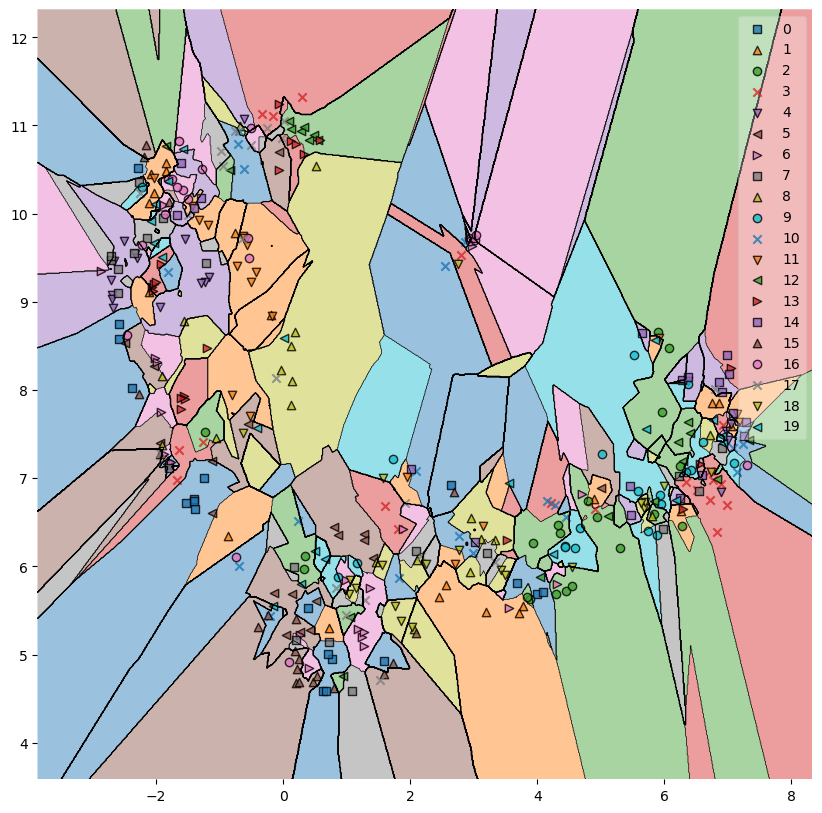

In [519]:
fig = plt.figure(figsize=(10,10))

plot_decision_regions(embedding_umap_tr, labels_tr, model)

plt.show()

<a id='g6'></a>
### Свои картинки

(224, 224, 3)


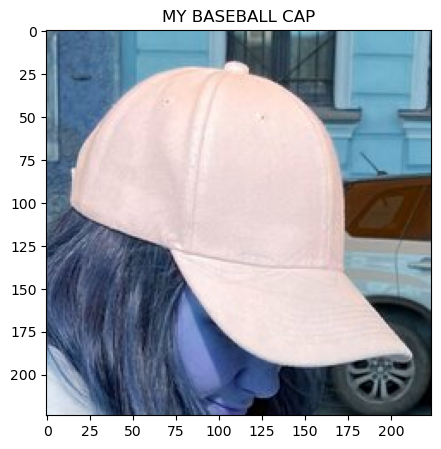

In [496]:
# img=mpimg.imread('cap.jpg')
img = cv2.imread('cap.jpg')

plt.figure(figsize=(5, 5))
imgplot = plt.imshow(img)
print(img.shape)
plt.title('MY BASEBALL CAP')
plt.show()

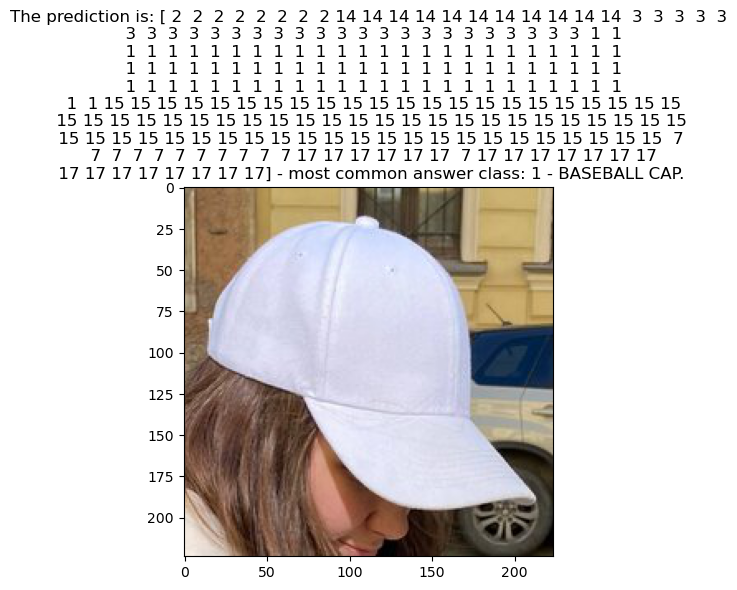

In [309]:
import umap.umap_ as umap

img = cv2.imread('cap.jpg')
imgGray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
# pixels = image_to_feature_vector(img)
# img_umap = umap.UMAP(n_components=2).fit_transform(imgGray)
img_st = StandardScaler().fit_transform(imgGray)

img_norm = Normalizer().fit_transform(img_st)

# imgGray_tsne = TSNE(n_components=2, perplexity=20).fit_transform(imgGray_normalized)
img_umap = umap.UMAP(n_components=2).fit_transform(img_norm)

# print(img_norm)
# print(img.shape)
output = model.predict(img_umap)

plt.imshow(mpimg.imread('cap.jpg'))
plt.title(f"The prediction is: {output} - most common answer class: {np.argmax(np.bincount(output))} - {mark.loc[mark[mark.class_id == np.argmax(np.bincount(output))].index[0], 'labels']}.")
plt.show()

In [473]:
def predict_image(img_path):
    img = cv2.imread(img_path)
    imgGray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img_st = StandardScaler().fit_transform(imgGray)
    img_norm = Normalizer().fit_transform(img_st)
    img_umap = umap.UMAP(n_components=2).fit_transform(img_norm)
    output = model.predict(img_umap)
    plt.imshow(mpimg.imread(img_path))
    plt.title(f"The prediction is: {output} - most common answer class: {np.argmax(np.bincount(output))} - {mark.loc[mark[mark.class_id == np.argmax(np.bincount(output))].index[0], 'labels']}.")
    plt.show()

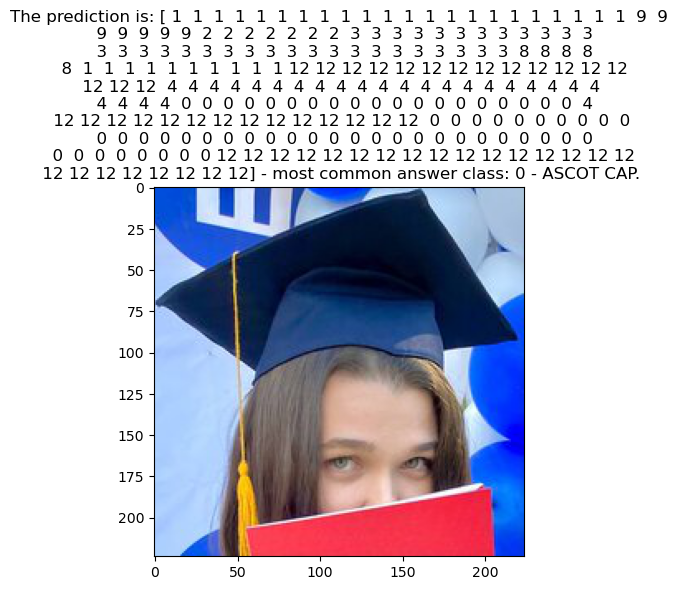

In [487]:
predict_image('mortarboard.jpg')

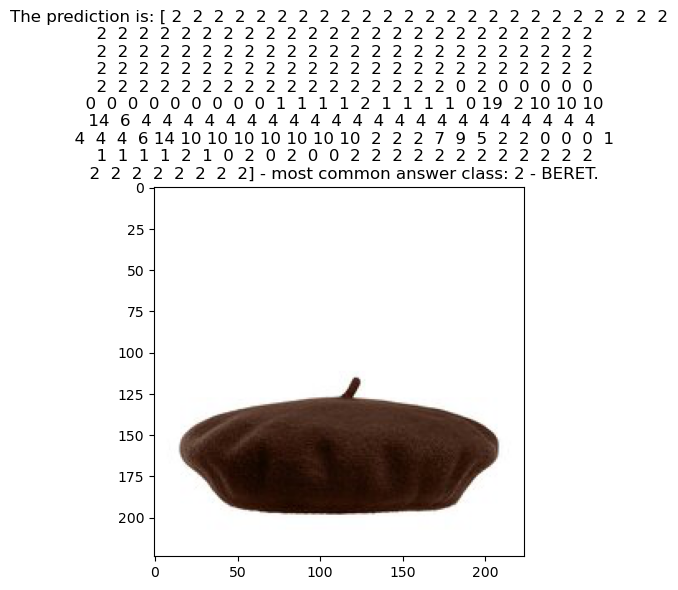

In [499]:
predict_image('beret.jpg')

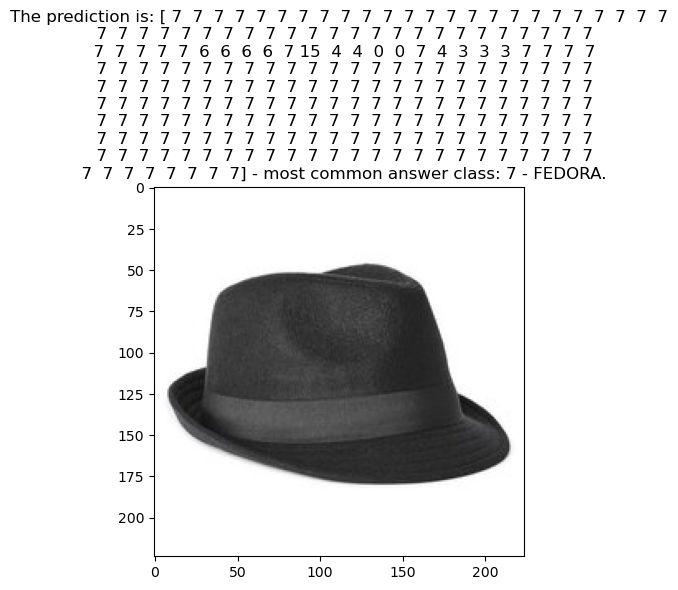

In [506]:
predict_image('fedora.jpg')

1. http://www.machinelearning.ru/wiki/index.php?title=Профиль_компактности
2. http://www.machinelearning.ru/wiki/index.php?title=Алгоритм_СТОЛП#:~:text=Алгоритм%20СТОЛП%20(STOLP)%20—%20алгоритм,эталонных%20объектов%20для%20метрического%20классификатора.
3. https://academy.yandex.ru/handbook/ml/article/metricheskiye-metody
4. https://jet1black.wordpress.com/2015/10/03/stolp-algorithm-implementation/
5. http://www.machinelearning.ru/wiki/index.php?title=Метод_парзеновского_окна
6. https://sebastianraschka.com/Articles/2014_kernel_density_est.html
7. https://rasbt.github.io/mlxtend/user_guide/plotting/plot_decision_regions/
8. https://pyimagesearch.com/2016/08/08/k-nn-classifier-for-image-classification/
9. https://www.kaggle.com/code/samuelcortinhas/intro-to-pca-t-sne-umap#UMAP
10. https://habr.com/ru/articles/651403/

[GO UP](#g0)

def compute_margins(xkd, x, y, u, u_ans, n):
    result = []
    bound = min(n, y.shape[0]) # задаем количество ближайших соседей для исследования
    
    for cur_u_idx, cur_u_coord in enumerate(u):  # задаем индекс каждой точке в u
        idx = xkd.query(cur_u_coord, bound)[1]  # сохраняем индексы ближайших соседей
        maj = {}
        
        for i in idx:
            y_cur = y[i]  # перебираем все класс в ближайших соседях по их индексу
            di = np.linalg.norm(cur_u_coord - x[i])  # расстояние от текущей точки до каждой точки в данных
            dn = np.linalg.norm(cur_u_coord - x[idx[bound - 1]])  # расстояние от текущей точки до предыдущей из n соседей
            w = 0.0
            
            if di != 0.0 and dn > di:
                w = dn / di
                
            maj[y_cur] = maj.get(y_cur, 0) + w  # обновляем в словаре по индексу точки ее вес, 
                                                # если новая точка, то ее вес 0 сначала
            
        cur_u_ans = u_ans[cur_u_idx] # находим в Y_train по текущему индексу класс [u_ans[cur_u_idx]][0]
        correct_score = maj.get(cur_u_ans, 0)  # достаем из словаря вес точки
        del maj[cur_u_ans]
        
        max_wrong = 0
        if len(maj) > 0:
            max_wrong = sorted(maj.items(), key=lambda x: x[1])[-1][1] # находим максимально отдаленный элемент (точку)
            
        result.append(correct_score - max_wrong)  # для рассчета конечной удаленности вычитаем самый большой отступ
        
    return np.array(result)

def stolp(src_x, src_y, err_num, depth_limit, n):

    support_x = []
    support_y = []
    src_xkd = KDTree(src_x)
    print(src_xkd)
    margins = np.array([compute_margins(src_xkd, src_x, src_y, src_x, src_y, n)]).transpose()
    
    x = src_x[margins[:, 0] > depth_limit]
    y = src_y[margins[:, 0] > depth_limit]
    margins = margins[margins[:, 0] > depth_limit]
    sorted_margs = np.argsort(margins[:, 0])

    for ans in np.unique(y):
        for m in sorted_margs:

            if y[m] == ans:

                support_x.append(x[m])
                support_y.append(y[m])
                x = np.delete(x, (m), axis=0)
                y = np.delete(y, (m), axis=0)
                break
                
    errors = x.shape[0]
    
    while errors > err_num:
        xkd = KDTree(np.array(support_x))
        margins = compute_margins(xkd, np.array(support_x), np.array(support_y), x, y, n)
        KNN_preds = model.predict(support_x)

        errors = len(KNN_preds[KNN_preds == src_y[:len(KNN_preds)]])
        sorted_margs = np.argsort(margins)  # выводим индексы отсортированных отступов
        to_delete = []
        min = sorted_margs[0]
        support_x.append(x[min])
        support_y.append(y[min])
        to_delete.append(min)
        
        x = np.delete(x, to_delete, axis=0)
        y = np.delete(y, to_delete, axis=0)
        
    return np.array(support_x), np.array(support_y)